# Imports and basic utilities

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patchify
import random
import time
import torch
import torchvision
import treadscan


def display_image(image: np.ndarray, filename: str = '') -> None:
    """Displays image using pyplot, specifing filename also writes to file"""
    
    dpi = 96
    shape = image.shape
    # Remove axes etc. from pyplot figure
    fig = plt.figure(figsize=(shape[1] // dpi, shape[0] // dpi), dpi=dpi, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Write image to file if filename specified
    if filename and len(filename) >= 5 and filename[-4:] in ['.jpg', '.png']:
        cv2.imwrite(filename, image)
        # fig.savefig(filename)

def scale_image(image: np.ndarray, factor: float, mode: int = -666) -> np.ndarray:
    """Return image scaled by factor"""
    
    # Compute resized shape
    scaled_shape = (int(image.shape[1] * factor), int(image.shape[0] * factor))
    
    if mode == -666:
        if factor < 1:
            mode = cv2.INTER_AREA
        else:
            mode = cv2.INTER_LINEAR
    
    return cv2.resize(image, scaled_shape, interpolation=mode)

def time_to_string(t):
    """Turn timestamp (seconds) to a human readable string"""
    
    return time.strftime("%H:%M:%S", time.gmtime(t))

def stack_images(image1: np.array, image2: np.array):
    """Stack grayscale images sideways (assuming they have the same height)"""
    
    image = np.zeros(shape=(image1.shape[0], image1.shape[1] + image2.shape[1]), dtype=np.uint8)
    image[:, :image1.shape[1]] = image1
    image[:, image1.shape[1]:] = image2
    
    return image

# Methods for preparing images to feed into our SRCNN

SRCNN takes 64x64 subimages (patches) as input and returns the sharpened 64x64 subimages. So we need methods to split each image into patches first. Luckily, there's a package called `patchify` which does this. We only need to slightly pad some images so that it can create patches with a given step size (stride).

In [2]:
def image_to_patches(image: np.array, step_size: int):
    """Creates 64x64 subimages from original image with given stride (step_size)"""
    # Calculate padding size
    padded_shape = image.shape[0] + step_size - image.shape[0] % step_size, image.shape[1] + step_size - image.shape[1] % step_size
    # Add reflective padding
    padded_image = np.pad(image, step_size, mode='reflect')[step_size:step_size + padded_shape[0], step_size:step_size + padded_shape[1]]
    
    return patchify.patchify(padded_image, (64, 64), step=step_size)

In [3]:
def patches_to_tensor(patches: np.array):
    """Turn array of patches into tensor ready to be used by a PyTorch model"""
    # Flatten second dimension
    flat_patches = patches.reshape(patches.shape[0] * patches.shape[1], 64, 64)
    # Convert range 0-255 to 0-1
    flat_patches = flat_patches.astype(np.float32) / 255
    # Add channel dimension
    return torch.tensor(flat_patches, dtype=torch.float).unsqueeze(0).swapaxes(0, 1)

In [4]:
def tensor_to_patches(tensor: torch.tensor, patches_shape: tuple):
    """Turn tensor of patches into 2D array of patches of given shape"""
    # Remove channel dimension from tensor, convert to array
    flat_patches = tensor.swapaxes(0, 1).squeeze(0).detach().cpu().numpy()
    # Reshape into desired shape
    patches = flat_patches.reshape(patches_shape[0], patches_shape[1], 64, 64)
    # Convert from 0-1 to 0-255
    return (patches.clip(0, 1) * 255).astype(np.uint8)

In [5]:
def patches_to_image(patches: np.array, image_shape: tuple, step_size: int):
    """Reconstruct image from 2D array of patches"""
    # Patches might include padding due to stride and original image size mismatch, calculate the padded image shape
    padded_shape = image_shape[0] + step_size - image_shape[0] % step_size, image_shape[1] + step_size - image_shape[1] % step_size
    padded_image = patchify.unpatchify(patches, padded_shape)
    # Remove padding
    return padded_image[:image_shape[0], :image_shape[1]]

In [6]:
def downsample_image(image: np.array, downscale_factor: int, modes: tuple = (cv2.INTER_AREA, cv2.INTER_LINEAR)):
    """Return image of the same size, but with less detail"""
    img = cv2.resize(scale_image(image, 1/downscale_factor, modes[0]), (image.shape[1], image.shape[0]), interpolation=modes[1])
    return cv2.blur(img, (8, 8))

## Measuring performance

To measure 'upscaling precision' we can use the peak signal-to-noise ratio (PSNR) measured in decibels.
$$\text{PSNR}(I_1, I_2) = 20 \cdot \log_{10} \left( \frac{\text{MAX}_I}{\sqrt{\text{MSE}(I_1, I_2)}} \right)$$

$\text{MAX_I}$ is the maximum possible value of the image (255 in our case). <br>
$\text{MSE}(I_1, I_2)$ is the mean square error of the two images $I_1$ and $I_2$.

In [7]:
def psnr(image1: np.array, image2: np.array):
    """Calculate peak signal-to-noise ratio (dB) of two images"""
    # Resize image if sizes don't match
    if image1.shape[0] != image2.shape[0] or image1.shape[1] != image2.shape[1]:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]), cv2.INTER_CUBIC)
    # Calculate PSNR
    rmse = np.sqrt(np.mean((image1.astype(np.int32) - image2.astype(np.int32))**2))
    if rmse == 0:
        return 100
    else:
        return 20 * np.log10(255 / rmse)

# Loading training data

Images of scanned tire treads that are split into 3 categories:
- good_focus: Treads in high resolution, perfect for training.
- mid_focus: Treads that are still 'readable', but not as good as good_focus.
- bad_focus: Images with very low resolution or 'unreadable' treads.

We'll be using mostly the high resolution images for training, but also mix in some from the other categories. The testing set will contain about similar amount of images from all the categories.

In [8]:
# Load images with high resolution (good quality images)
folder = '../data/treads_good_focus/'
high_res = [cv2.imread(folder + image, cv2.IMREAD_GRAYSCALE) for image in os.listdir(folder)]
# Sort by size (descending)
high_res.sort(key=lambda image: -image.shape[0] * image.shape[1])

# Okay quality images
folder = '../data/treads_mid_focus/'
mid_res = [cv2.imread(folder + image, cv2.IMREAD_GRAYSCALE) for image in os.listdir(folder)]
mid_res.sort(key=lambda image: -image.shape[0] * image.shape[1])

# Bad quality images
folder = '../data/treads_bad_focus/'
low_res = [cv2.imread(folder + image, cv2.IMREAD_GRAYSCALE) for image in os.listdir(folder)]
low_res.sort(key=lambda image: -image.shape[0] * image.shape[1])

In [9]:
# Shuffle images (using a seed)
random.seed(666)
high_res = random.sample(high_res, len(high_res))
mid_res = random.sample(mid_res, len(mid_res))
low_res = random.sample(low_res, len(low_res))

In [10]:
# Split into training and testing sets
training_set = high_res[:40] + mid_res[:15] + low_res[:5]
testing_set = high_res[40:45] + mid_res[15:20] + low_res[5:10]

# Filter out images that are too small (SRCNN works with 64x64 subimages)
training_set = [image for image in training_set if image.shape[0] >= 64 and image.shape[1] >= 64]
testing_set = [image for image in testing_set if image.shape[0] >= 64 and image.shape[1] >= 64]

# Shuffle both sets, to mix high/mid/low res images
training_set = random.sample(training_set, len(training_set))
testing_set = random.sample(testing_set, len(testing_set))

# Print info about their sizes
train = len(training_set)
test = len(testing_set)
print(f'Training images: {train}, ({train / (train + test) * 100:.2f} %)')
print(f'Testing images: {test}, ({(1 - (train / (train + test))) * 100:.2f} %)')

Training images: 59, (80.82 %)
Testing images: 14, (19.18 %)


## Estimating the training time

The authors of the original SRCNN paper tested their models after $8\cdot10^8$ backpropagations 😱. We'll ease up *a little*, but just to compare:

In [11]:
# Upscale factor - determines the downsampling frequency of training images
factor = 4

# Stride of image patches - determines how many subimages an image will be split into
step_size = 4

# Count the total number of subimages of the training set to calculate training time
total_patches = 0
for img in training_set:
    total_patches += len(image_to_patches(img, step_size))

# On the declared training set, using RTX 3060 Mobile
estimated_seconds_per_epoch = 130

# Original SRCNN paper: 8*10**8 backpropagations
target_backpropagations = 8*10**8

total_training_time = target_backpropagations // total_patches * estimated_seconds_per_epoch
days = total_training_time // (60 * 60 * 24)
hours = (total_training_time - days * 60 * 60 * 24) // (60 * 60)
minutes = (total_training_time - days * 60 * 60 * 24 - 60 * 60 * hours) // 60

print(f'Training patches: {total_patches}')
print(f'Number of epochs required to do {target_backpropagations} backpropagations: {target_backpropagations // total_patches}')
print(f"Estimated training time: {days} day{'s' if days != 1 else ''}, {hours} hour{'s' if hours != 1 else ''} and {minutes} minute{'s' if minutes != 1 else ''}")

Training patches: 9120
Number of epochs required to do 800000000 backpropagations: 87719
Estimated training time: 131 days, 23 hours and 37 minutes


## Data augmentation

To introduce more diversity among our training images, we'll roll the dice 🎲 to transform the image slightly, before training on it.

In [12]:
def transform(image: np.array) -> np.array:
    """Data augmentation method"""
    transformed = image
    
    r = random.random()
    # 10 % chance to remove light gradient from image
    if 0 <= r < 0.1:
        transformed = treadscan.remove_gradient(transformed)
    # 50 % chance to equalize histogram
    elif 0.1 <= r < 0.6:
        transformed = treadscan.remove_gradient(transformed)
        transformed = treadscan.clahe(transformed)
        
    r = random.random()
    # 15 % chance to rotate image (90, 180 or 270 degrees)
    if 0 <= r < 0.05:
        transformed = np.rot90(transformed)
    elif 0.05 <= r < 0.1:
        transformed = np.rot90(transformed)
        transformed = np.rot90(transformed)
    elif 0.1 <= r < 0.15:
        transformed = np.rot90(image)
        transformed = np.rot90(transformed)
        transformed = np.rot90(transformed)
    
    r = random.random()
    # 15 % chance to flip image (vertically or horizontally)
    if 0 <= r < 0.075:
        transformed = np.flip(transformed, 1)
    elif 0.075 <= r < 0.15:
        transformed = np.flip(transformed, 0)
        
    return transformed

## Training data preview

The downsampled training image is on the left, the target image is on the right.

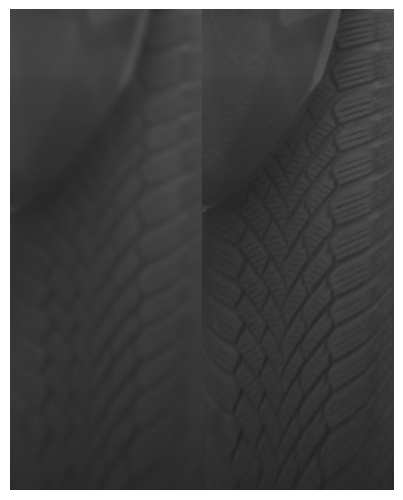

In [13]:
original_image = transform(training_set[0])
downsampled_image = downsample_image(original_image, factor)

display_image(stack_images(downsampled_image, original_image))

# SRCNN Initialization

Using the 9-1-5 kernel structure. <br>
9-5-5 gets marginally better results, but takes much longer to train, as per https://arxiv.org/abs/1501.00092.

In [14]:
class SRCNN(torch.nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=9, stride=(1, 1), padding=(2, 2), padding_mode='reflect')
        self.conv2 = torch.nn.Conv2d(64, 32, kernel_size=1, stride=(1, 1), padding=(2, 2), padding_mode='reflect')
        self.conv3 = torch.nn.Conv2d(32, 1, kernel_size=5, stride=(1, 1), padding=(2, 2), padding_mode='reflect')
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    
    def upsample(self, image: np.array, factor: int = 4, batch_size: int = 500) -> np.array:
        with torch.no_grad():
            # Prepare image
            upscaled_image = scale_image(image, factor)
            patches = image_to_patches(upscaled_image, 64)
            tensors = patches_to_tensor(patches).split(batch_size)

            # Upscale it (in batches)
            outputs = []
            for batch in tensors:
                output = self(batch.to(device))
                outputs.append(output.detach().cpu())

            # Reconstruct it
            outputs = torch.cat(outputs)
            output_patches = tensor_to_patches(outputs, (patches.shape[0], patches.shape[1]))
            output_image = patches_to_image(output_patches, upscaled_image.shape, 64)
            
            return output_image

In [15]:
class SmallSRCNN(torch.nn.Module):
    def __init__(self):
        super(SmallSRCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 36, kernel_size=9, stride=(1, 1), padding=(4, 4), padding_mode='reflect')
        self.conv3 = torch.nn.Conv2d(36, 1, kernel_size=5, stride=(1, 1), padding=(2, 2), padding_mode='reflect')
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.conv3(x)
        return x
    
    def upsample(self, image: np.array, factor: int = 4, batch_size: int = 500) -> np.array:
        with torch.no_grad():
            # Prepare image
            upscaled_image = scale_image(image, factor)
            patches = image_to_patches(upscaled_image, 64)
            tensors = patches_to_tensor(patches).split(batch_size)

            # Upscale it (in batches)
            outputs = []
            for batch in tensors:
                output = self(batch.to(device))
                outputs.append(output.detach().cpu())

            # Reconstruct it
            outputs = torch.cat(outputs)
            output_patches = tensor_to_patches(outputs, (patches.shape[0], patches.shape[1]))
            output_image = patches_to_image(output_patches, upscaled_image.shape, 64)
            
            return output_image

In [16]:
class SmallestSRCNN(torch.nn.Module):
    def __init__(self):
        super(SmallestSRCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 9, kernel_size=9, stride=(1, 1), padding=(4, 4), padding_mode='reflect')
        self.conv2 = torch.nn.Conv2d(9, 1, kernel_size=5, stride=(1, 1), padding=(2, 2), padding_mode='reflect')
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.conv2(x)
        return x
    
    def upsample(self, image: np.array, factor: int = 4, batch_size: int = 500) -> np.array:
        with torch.no_grad():
            # Prepare image
            upscaled_image = scale_image(image, factor)
            patches = image_to_patches(upscaled_image, 64)
            tensors = patches_to_tensor(patches).split(batch_size)

            # Upscale it (in batches)
            outputs = []
            for batch in tensors:
                output = self(batch.to(device))
                outputs.append(output.detach().cpu())

            # Reconstruct it
            outputs = torch.cat(outputs)
            output_patches = tensor_to_patches(outputs, (patches.shape[0], patches.shape[1]))
            output_image = patches_to_image(output_patches, upscaled_image.shape, 64)
            
            return output_image

## Load trained model

If it exists.

In [17]:
def load_training_data(file: str = 'psnr.csv') -> tuple:
    if os.path.isfile(file):
        df = pd.read_csv(file, header=0)
        training_psnr = df['training_psnr'].tolist()
        testing_psnr = df['testing_psnr'].tolist()
        training_loss = df['training_loss'].tolist()
        trained_epochs = len(df)
    
        return training_psnr, testing_psnr, training_loss, trained_epochs
    print('File not found.')
    return [], [], [], 0
    
def load_model(model: SRCNN, file: str):
    if os.path.isfile(file):
        model.load_state_dict(torch.load(file))
    else:
        print('File not found.')

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SRCNN().to(device)

training_psnr, testing_psnr, training_loss, trained_epochs = load_training_data('srcnn/psnr.csv')
load_model(model, f'srcnn/srcnn_{trained_epochs}epochs.pth')

## Training parameters

In [20]:
model.train()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

batch_size = 500

In [22]:
# Epochs to train right now
epochs = 250
# Animation frame number (grid of learned filters)
frame_idx = 0

time_start = time.time()
# Epoch
for epoch in range(trained_epochs, trained_epochs + epochs):
    img_idx = 0
    model.train()
    epoch_psnr = []
    epoch_losses = []
    
    # Shuffle training images between epochs
    for original_image in random.sample(training_set, len(training_set)):
        # Save grid of learned filters of the first layer for animation purposes
        if img_idx % 5 == 0:
            c1 = filter_grid(model.conv1.weight.data.clone().cpu(), unsorted=True)
            c1 = scale_image(c1, 10, cv2.INTER_AREA)
            c2 = filter_grid(model.conv2.weight.data.clone().cpu(), unsorted=True, padding=0)
            c2 = scale_image(c2, 20, cv2.INTER_AREA)
            cv2.imwrite(f'conv1_animation/{frame_idx:05d}.png', c1)
            cv2.imwrite(f'conv2_animation/{frame_idx:05d}.png', c2)
            frame_idx += 1
        
        # Apply random transformation to training image
        original_image = transform(original_image)
        downsampled_image = downsample_image(original_image, factor)
        
        # Get raw target and input data (64x64 subimages)
        original_patches = image_to_patches(original_image, step_size)
        downsampled_patches = image_to_patches(downsampled_image, step_size)
        
        # Split image into smaller batches (my GPU has only 6GiB of memory)        
        tensors = patches_to_tensor(downsampled_patches).split(batch_size)
        tensor_targets = patches_to_tensor(original_patches).split(batch_size)

        outputs = []
        for i in range(len(tensors)):
            # Train the model
            optimizer.zero_grad()
            output = model(tensors[i].to(device))
            loss = criterion(output, tensor_targets[i].to(device))
            loss.backward()
            optimizer.step()
            
            # Save the result for image reconstruction
            outputs.append(output.detach().cpu())
            epoch_losses.append(loss.item())
            
        # Reconstruct the output image
        outputs = torch.cat(outputs)
        output_patches = tensor_to_patches(outputs, (downsampled_patches.shape[0], downsampled_patches.shape[1]))
        output_image = patches_to_image(output_patches, downsampled_image.shape, step_size)
        
        # Calculate PSNR
        epoch_psnr.append(psnr(original_image, output_image))
           
        # Print epoch progress
        img_idx += 1
        print(f'\r[{time_to_string(time.time() - time_start)}] Epoch {epoch + 1}: {img_idx}/{len(training_set)}', end='    ')
    
    # Print epoch results
    training_psnr.append(np.mean(epoch_psnr))
    training_loss.append(np.mean(epoch_losses))
    print(f'        Average training PSNR: {training_psnr[-1]:.4f}')
    trained_epochs += 1
    
    # Testing
    img_idx = 0
    model.eval()
    epoch_psnr = []
    with torch.no_grad():
        for original_image in random.sample(testing_set, len(testing_set)):
            # Prepare downsampled image
            downsampled_image = downsample_image(original_image, factor)
            original_patches = image_to_patches(original_image, step_size)
            downsampled_patches = image_to_patches(downsampled_image, step_size)
            tensors = patches_to_tensor(downsampled_patches).split(batch_size)

            # Upscale it (in batches)
            outputs = []
            for batch in tensors:
                output = model(batch.to(device))
                outputs.append(output.detach().cpu())

            # Reconstruct it
            outputs = torch.cat(outputs)
            output_patches = tensor_to_patches(outputs, (downsampled_patches.shape[0], downsampled_patches.shape[1]))
            output_image = patches_to_image(output_patches, downsampled_image.shape, step_size)

            # Calculate PSNR
            epoch_psnr.append(psnr(original_image, output_image))
            
            # Print testing progress
            img_idx += 1
            print(f'\r[{time_to_string(time.time() - time_start)}] Evaluating model {img_idx}/{len(testing_set)}', end='    ')
        
        # Print testing results
        testing_psnr.append(np.mean(epoch_psnr))
        print(f'Average testing PSNR: {testing_psnr[-1]:.4f}')
        
    # Write trained model to disk to save progress
    if trained_epochs % 10 == 0:
        torch.save(model.state_dict(), f'srcnn_{trained_epochs}epochs.pth')
        pd.DataFrame({'training_psnr': training_psnr, 'testing_psnr': testing_psnr, 'training_loss': training_loss}).to_csv('psnr.csv', header=True, index=False)
        
torch.save(model.state_dict(), f'srcnn_{trained_epochs}epochs.pth')
pd.DataFrame({'training_psnr': training_psnr, 'testing_psnr': testing_psnr, 'training_loss': training_loss}).to_csv('psnr.csv', header=True, index=False)

[00:00:55] Epoch 1: 59/59            Average training PSNR: 25.9132
[00:00:59] Evaluating model 14/14    Average testing PSNR: 32.6365
[00:01:58] Epoch 2: 59/59            Average training PSNR: 28.5783
[00:02:02] Evaluating model 14/14    Average testing PSNR: 32.7361
[00:02:58] Epoch 3: 59/59            Average training PSNR: 27.0841
[00:03:02] Evaluating model 14/14    Average testing PSNR: 32.9448
[00:03:56] Epoch 4: 59/59            Average training PSNR: 29.2295
[00:04:00] Evaluating model 14/14    Average testing PSNR: 32.9180
[00:04:54] Epoch 5: 59/59            Average training PSNR: 28.6077
[00:04:58] Evaluating model 14/14    Average testing PSNR: 33.3300
[00:05:52] Epoch 6: 59/59            Average training PSNR: 28.4082
[00:05:56] Evaluating model 14/14    Average testing PSNR: 33.8054
[00:06:51] Epoch 7: 59/59            Average training PSNR: 29.7683
[00:06:54] Evaluating model 14/14    Average testing PSNR: 33.9006
[00:07:49] Epoch 8: 59/59            Average training P

[01:02:25] Evaluating model 14/14    Average testing PSNR: 33.8601
[01:03:22] Epoch 62: 59/59            Average training PSNR: 30.8152
[01:03:26] Evaluating model 14/14    Average testing PSNR: 33.8551
[01:04:22] Epoch 63: 59/59            Average training PSNR: 30.2035
[01:04:27] Evaluating model 14/14    Average testing PSNR: 33.9348
[01:05:24] Epoch 64: 59/59            Average training PSNR: 29.9378
[01:05:29] Evaluating model 14/14    Average testing PSNR: 33.7572
[01:06:27] Epoch 65: 59/59            Average training PSNR: 29.9184
[01:06:31] Evaluating model 14/14    Average testing PSNR: 33.9532
[01:07:29] Epoch 66: 59/59            Average training PSNR: 30.2146
[01:07:33] Evaluating model 14/14    Average testing PSNR: 33.9387
[01:08:30] Epoch 67: 59/59            Average training PSNR: 29.7300
[01:08:34] Evaluating model 14/14    Average testing PSNR: 33.9634
[01:09:30] Epoch 68: 59/59            Average training PSNR: 30.3985
[01:09:34] Evaluating model 14/14    Average tes

[03:07:36] Evaluating model 14/14    Average testing PSNR: 33.7870
[03:08:35] Epoch 182: 59/59            Average training PSNR: 29.6583
[03:08:39] Evaluating model 14/14    Average testing PSNR: 33.9108
[03:09:38] Epoch 183: 59/59            Average training PSNR: 30.6791
[03:09:43] Evaluating model 14/14    Average testing PSNR: 34.0011
[03:10:42] Epoch 184: 59/59            Average training PSNR: 29.5515
[03:10:46] Evaluating model 14/14    Average testing PSNR: 34.0328
[03:11:45] Epoch 185: 59/59            Average training PSNR: 29.8185
[03:11:49] Evaluating model 14/14    Average testing PSNR: 33.8256
[03:12:47] Epoch 186: 59/59            Average training PSNR: 29.6728
[03:12:51] Evaluating model 14/14    Average testing PSNR: 33.8362
[03:13:49] Epoch 187: 59/59            Average training PSNR: 29.6606
[03:13:54] Evaluating model 14/14    Average testing PSNR: 33.9099
[03:14:52] Epoch 188: 59/59            Average training PSNR: 29.9317
[03:14:57] Evaluating model 14/14    Aver

[04:08:50] Evaluating model 14/14    Average testing PSNR: 33.9760
[04:09:47] Epoch 242: 59/59            Average training PSNR: 30.1017
[04:09:50] Evaluating model 14/14    Average testing PSNR: 34.0583
[04:10:47] Epoch 243: 59/59            Average training PSNR: 29.9946
[04:10:51] Evaluating model 14/14    Average testing PSNR: 33.8144
[04:11:52] Epoch 244: 59/59            Average training PSNR: 28.3665
[04:11:56] Evaluating model 14/14    Average testing PSNR: 33.9747
[04:12:56] Epoch 245: 59/59            Average training PSNR: 28.8557
[04:13:01] Evaluating model 14/14    Average testing PSNR: 33.6891
[04:14:01] Epoch 246: 59/59            Average training PSNR: 30.7798
[04:14:05] Evaluating model 14/14    Average testing PSNR: 34.0561
[04:15:05] Epoch 247: 59/59            Average training PSNR: 29.4126
[04:15:10] Evaluating model 14/14    Average testing PSNR: 33.9879
[04:16:10] Epoch 248: 59/59            Average training PSNR: 30.3602
[04:16:14] Evaluating model 14/14    Aver

# Visualizing learned filters

The first layer is the most interesting one, because it works directly on the input image. Thus we can also better 'read' the filters, because they can relate to some known real-world filters such as a edge detection, Gaussian etc.

In [19]:
def filter_grid(tensor, unsorted: bool = False, padding: int = 1, over_channels: bool = False):
    """Display learned filters sorted by variance"""
    
    n, channels, w, h = tensor.shape
    if over_channels:
        filters = []
        nrow = int(np.sqrt(channels))
        ncol = int(np.ceil(channels / nrow))
        for c in range(channels):
            t = tensor[0, c, :, :].unsqueeze(dim=0)

            line = torchvision.utils.make_grid(t, nrow=1, normalize=True, padding=0)
            line = (line.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)

            for i in range(n):
                filters.append(cv2.cvtColor(line[i * h:h + i * h, 0:w, :], cv2.COLOR_BGR2GRAY))
    else:
        tensor = tensor[:, 0, :, :].unsqueeze(dim=1)
 
        nrow = int(np.sqrt(n))
        ncol = int(np.ceil(n / nrow))

        line = torchvision.utils.make_grid(tensor, nrow=1, normalize=True, padding=0)
        line = (line.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)

        filters = []
        for i in range(n):
            filters.append(cv2.cvtColor(line[i * h:h + i * h, 0:w, :], cv2.COLOR_BGR2GRAY))
    
    # Sort filters by variance (descending)
    if not unsorted:
        filters.sort(key=lambda x: -np.var(x))
        
    p = padding
    
    gh = nrow * h + p * (nrow + 1)
    gw = ncol * w + p * (ncol + 1)
    
    # Create new filter grid with padding
    grid = np.zeros((gh, gw), np.uint8)
    for i in range(nrow):
        for j in range(ncol):
            grid[p+i*(h+p):p+(i+1)*(h+p)-p, p+j*(w+p):p+(j+1)*(w+p)-p] = filters[i*nrow+j]
    
    return grid

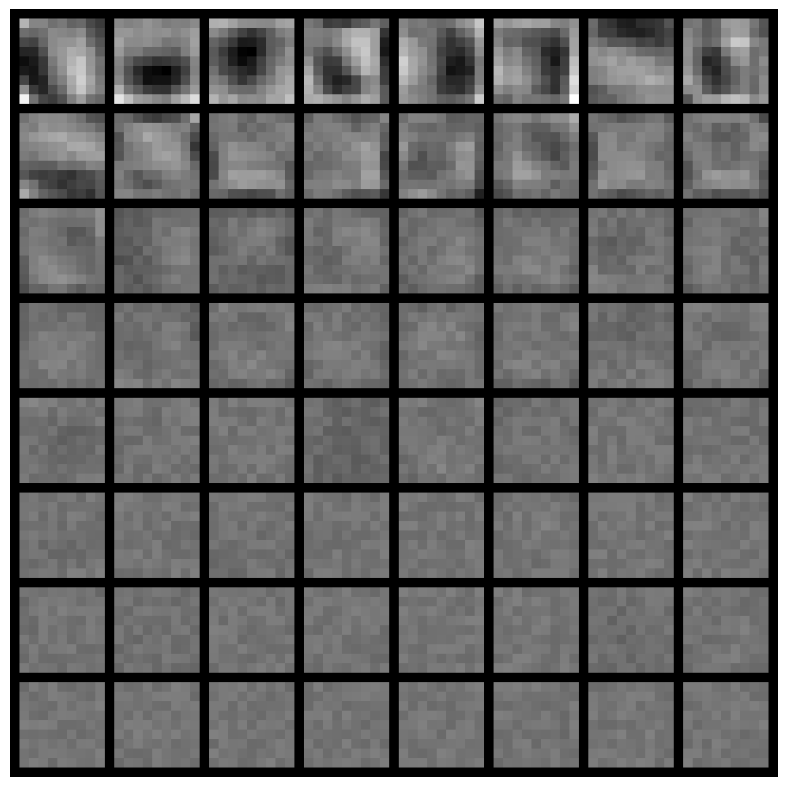

In [21]:
grid = filter_grid(model.conv1.weight.data.clone().cpu(), padding=1)
display_image(scale_image(grid, 10, cv2.INTER_AREA))

In [52]:
# Animating filter learning process
# ffmpeg -f image2 -framerate 5 -i %05d.png -loop -1 filters.gif
# ffmpeg -i filters.gif -profile:v high -pix_fmt yuv420p -g 300 -filter:v "setpts=PTS/8" filters.mp4
i = 0
for ep in range(1, 251):
    model = SmallestSRCNN().to(device)
    load_model(model, f'smallest_srcnn/srcnn_{ep}epochs.pth')
    grid = filter_grid(model.conv2.weight.data.clone().cpu(), unsorted=True, over_channels=True)
    grid = scale_image(grid, 20, cv2.INTER_AREA)
    cv2.imwrite(f'anim/{i:05d}.png', grid)
    i += 1

# Comparison of different upscaling methods

I'll be comparing the SRCNN model trained on my grayscale data against other models, which have been trained on more generalized color images.

Models available in OpenCV:
- EDSR: https://arxiv.org/abs/1707.02921
- ESPCN: https://arxiv.org/abs/1609.05158
- FSRCNN: https://arxiv.org/abs/1608.00367
- LapSRN: https://arxiv.org/abs/1710.01992

Pretrained models available for download here:
- EDSR: https://github.com/Saafke/EDSR_Tensorflow/tree/master/models
- ESPCN: https://github.com/fannymonori/TF-ESPCN/tree/master/export
- FSRCNN: https://github.com/Saafke/FSRCNN_Tensorflow/tree/master/models
- LapSRN: https://github.com/fannymonori/TF-LapSRN/tree/master/export

In [22]:
cv2_super_resolution_models = [
    ('EDSR_x4.pb', 'EDSR'),
    ('ESPCN_x4.pb', 'ESPCN'),
    ('FSRCNN_x4.pb', 'FSRCNN'),
    ('LapSRN_x4.pb', 'LapSRN')
]

In [23]:
# Saving results in dictionary
measured = {}
for m in cv2_super_resolution_models:
    # Initialize model
    sr = cv2.dnn_superres.DnnSuperResImpl_create()
    sr.readModel(f'/home/daniel/Downloads/{m[0]}') 
    sr.setModel(str.lower(m[1]), factor)

    # Upscale all testing images
    psnr_list = []
    for original_image in testing_set:
        downsampled_image = scale_image(downsample_image(original_image, factor), 1/factor)
        # Upscale using OpenCV's model
        output_image = sr.upsample(cv2.cvtColor(downsampled_image, cv2.COLOR_GRAY2BGR))
        output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)
        psnr_list.append(psnr(original_image, output_image))

    # Save average PSNR
    measured[m[1]] = np.mean(psnr_list)

In [24]:
psnr_list = []
for original_image in testing_set:
    downsampled_image = scale_image(downsample_image(original_image, factor), 1/factor)
    # Upscale using bicubic interpolation
    output_image = cv2.resize(downsampled_image, (original_image.shape[1], original_image.shape[0]), cv2.INTER_CUBIC)
    psnr_list.append(psnr(original_image, output_image))
    
measured['Bicubic'] = np.mean(psnr_list)

In [25]:
for p in [('less_downsampling/srcnn_250epochs.pth', 'SRCNN less downsampling'), ('srcnn/srcnn_10epochs.pth', 'SRCNN 10 Epochs'), ('srcnn/srcnn_250epochs.pth', 'SRCNN 250 Epochs')]:
    load_model(model, p[0])
    psnr_list = []
    for original_image in testing_set:
        downsampled_image = scale_image(downsample_image(original_image, factor), 1/factor)
        # Upscale using trained SRCNN
        output_image = model.upsample(downsampled_image, factor)
        psnr_list.append(psnr(original_image, output_image))

    measured[p[1]] = np.mean(psnr_list)

In [60]:
psnr_list = []
for i, original_image in enumerate(testing_set):
    srgan_img = cv2.imread(f'srgan_upsampled/{i}_up.jpg', cv2.IMREAD_GRAYSCALE)
    psnr_list.append(psnr(original_image, scale_image(srgan_img, 1/4)))
print(f'DeepAI SRGAN: {np.mean(psnr_list):.2f} dB')

measured['DeepAI SRGAN'] = np.mean(psnr_list)

DeepAI SRGAN: 30.92 dB


In [26]:
for k, v in sorted(measured.items(), key=lambda x: x[1]):
    print(f'{k}: {v:.2f} dB')

# SRCNN with dropout 50 Epochs was measured at only 18.6 dB

Bicubic: 29.83 dB
LapSRN: 30.15 dB
ESPCN: 30.30 dB
FSRCNN: 30.36 dB
EDSR: 30.40 dB
SRCNN less downsampling: 30.45 dB
SRCNN 10 Epochs: 31.30 dB
SRCNN 250 Epochs: 32.36 dB


In [61]:
measured = {
    'Bicubic': 29.83,
    'LapSRN': 30.15,
    'ESPCN': 30.30,
    'FSRCNN': 30.36,
    'EDSR': 30.40,
    'SRCNN less downsampling': 30.45,
    'SRCNN (250 epochs)': 32.36,
    'Small SRCNN (250 epochs)': 32.03,
    'Smallest SRCNN (250 epochs)': 32.11,
    'DeepAI SRGAN': 30.92
}

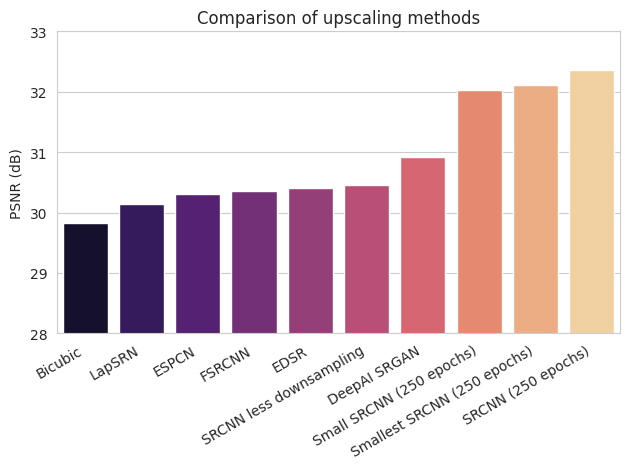

In [63]:
# Convert dictionary to pandas.DataFrame
comparisons = dict()
for k, v in sorted(measured.items(), key=lambda x: x[1]):
    comparisons[k] = [v]
comparisons = pd.DataFrame().from_dict(comparisons)

# Create a nice barplot
sns.set_style('whitegrid')
ax = sns.barplot(comparisons, palette='magma')
ax.set(ylim=(28, 33))
ax.set_title('Comparison of upscaling methods')
ax.set(ylabel='PSNR (dB)')
fig = plt.gcf()
fig.autofmt_xdate()
plt.tight_layout()
#plt.savefig('PSNR_comparison.svg')

In [124]:
models = ['srcnn', 'less_downsampling', 'dropout', 'small_srcnn', 'smallest_srcnn']
training_data = dict()
for m in models:
    data = pd.read_csv(f'{m}/psnr.csv', header=0)
    training_data[m] = data

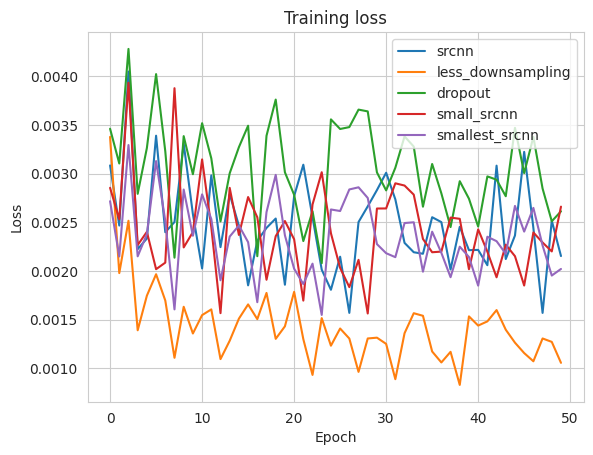

In [138]:
for m in models:
    plt.plot(training_data[m]['training_loss'][:50], label=m)

plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('training_loss.svg')

# Upscaling images using trained SRCNN

All the dirty stuff is implemented inside the `SRCNN.upsample` method. Calling it is very straightforward.

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SRCNN().to(device)

load_model(model, 'srcnn/srcnn_250epochs.pth')

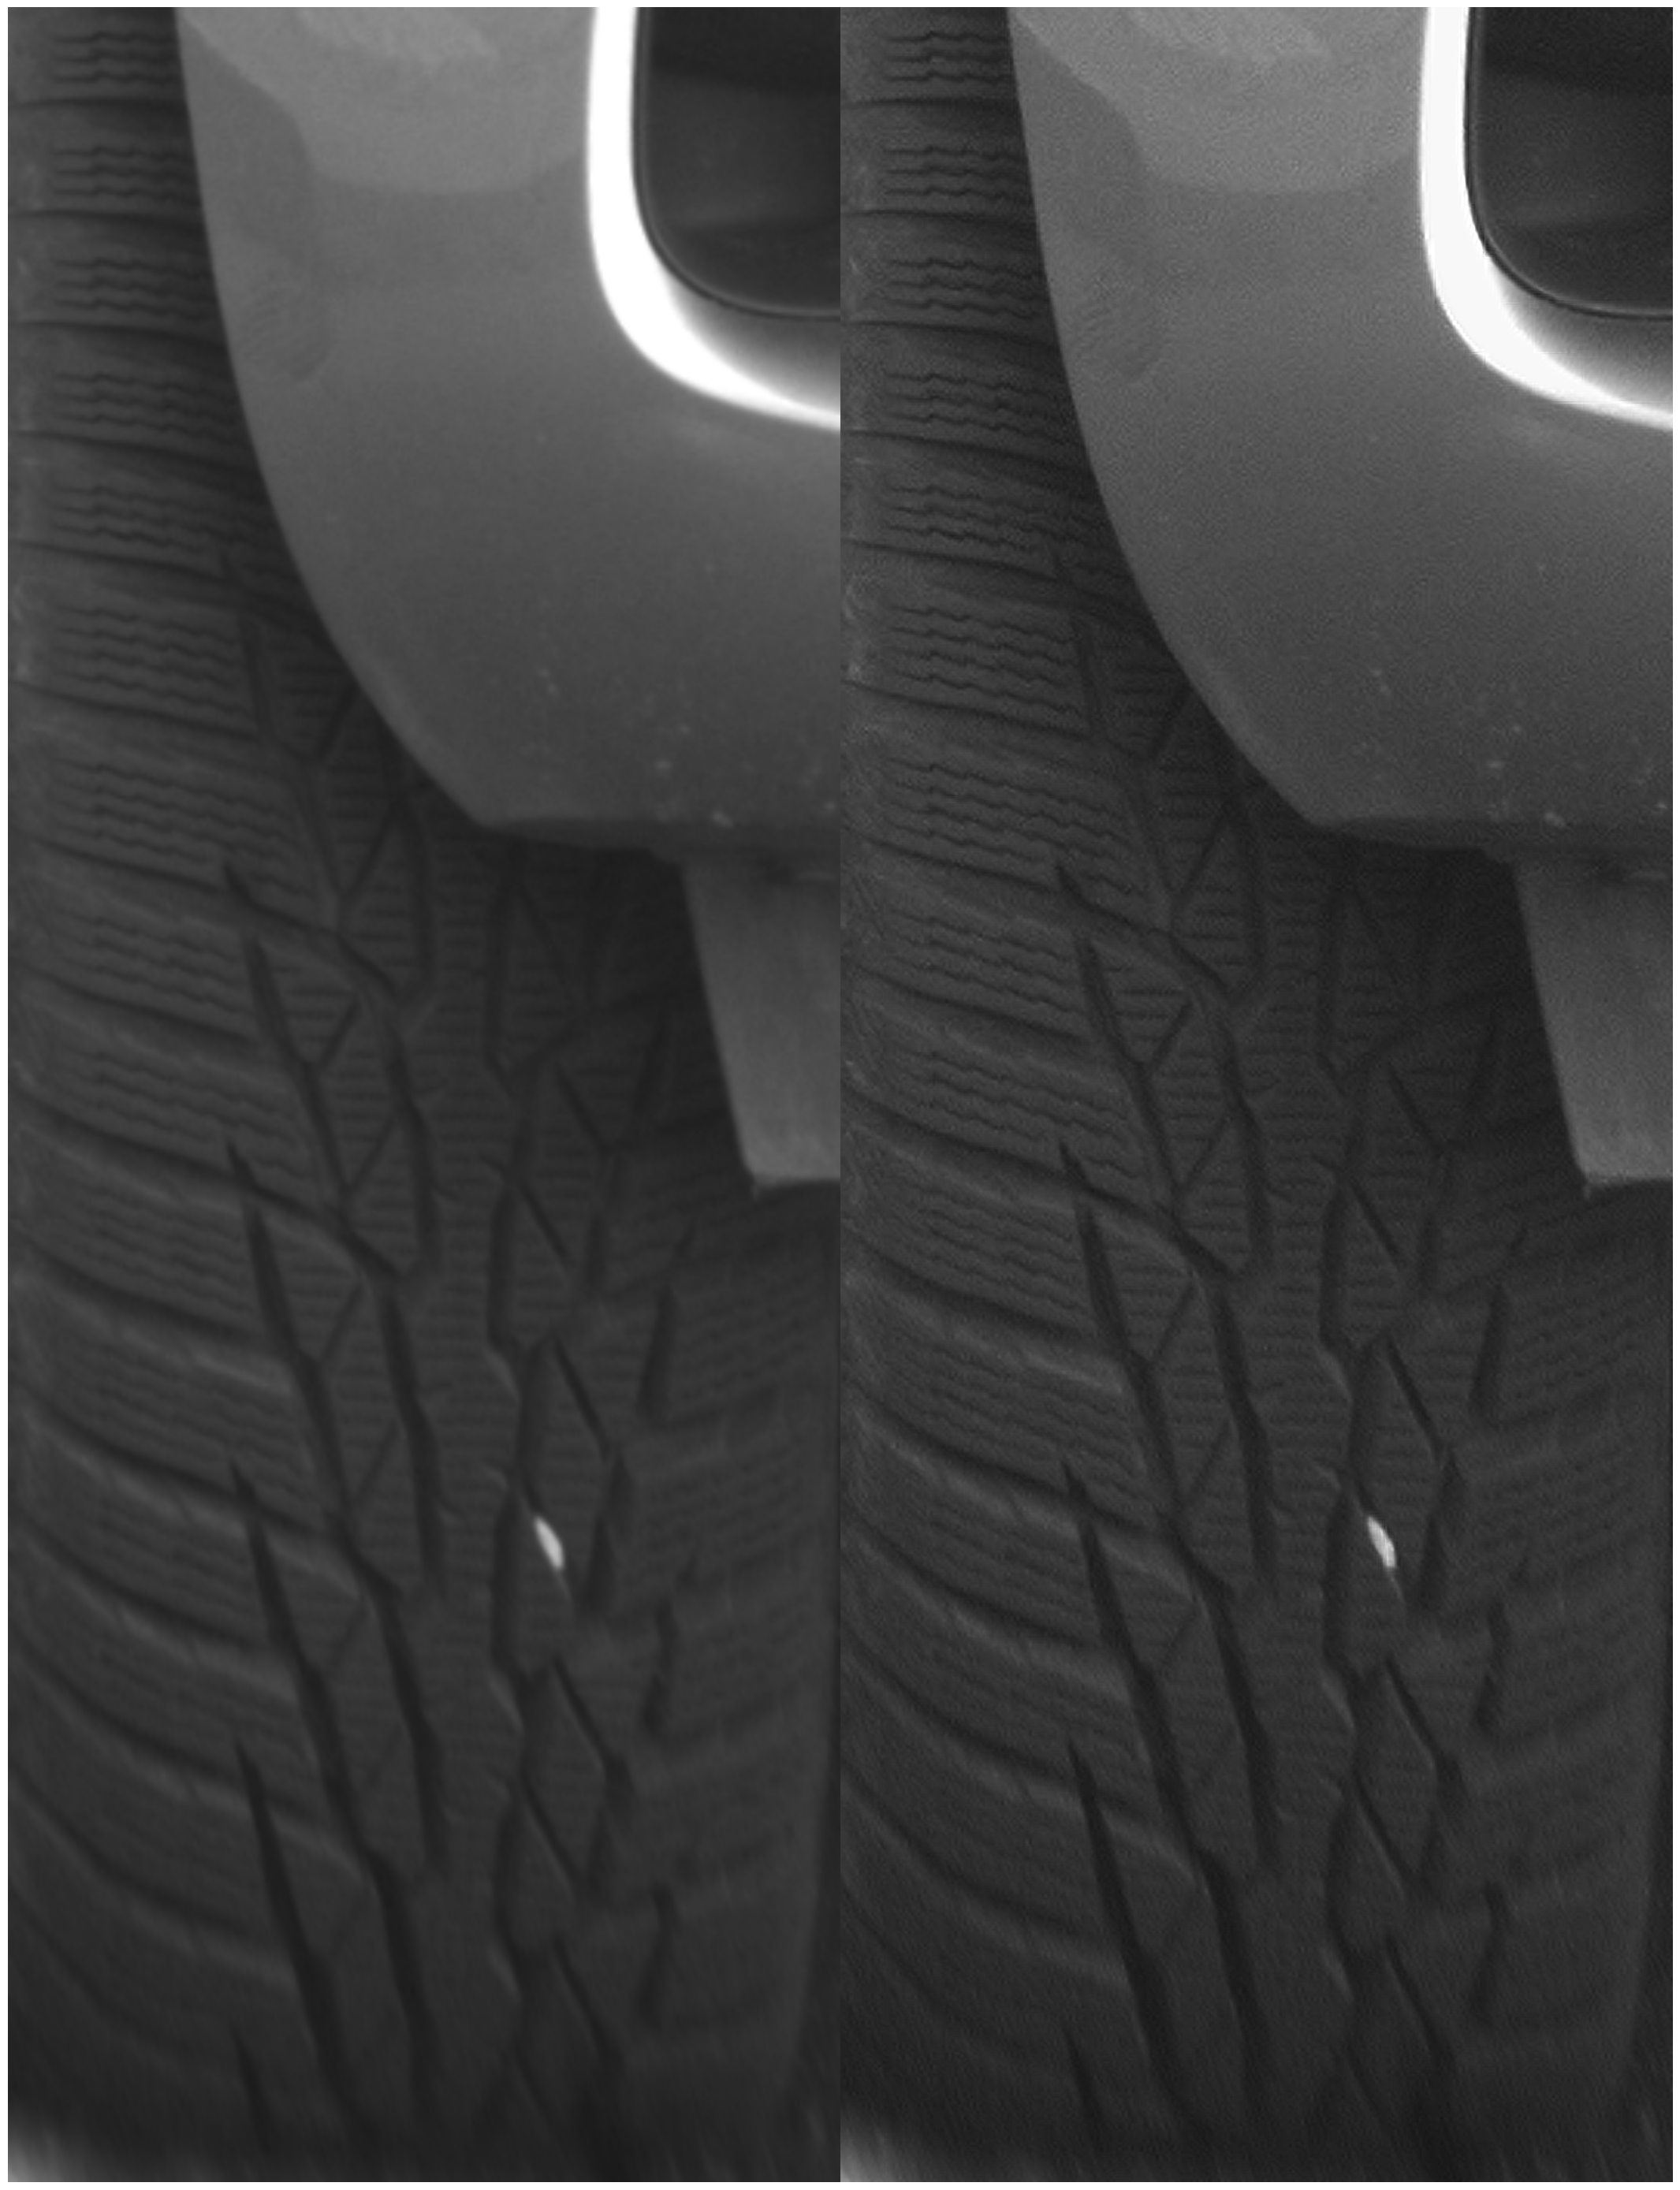

In [20]:
original_image = testing_set[1]
upscaled_image = model.upsample(original_image, factor)

# Attempt at removing random noise
# upscaled_image = cv2.medianBlur(upscaled_image, 5)

# Display upscaled image and the upscaled image sharpened by SRCNN
display_image(stack_images(scale_image(original_image, factor), upscaled_image))

By downscaling the image back to it's original size we essentially only remove the blur that might've been present in the original.

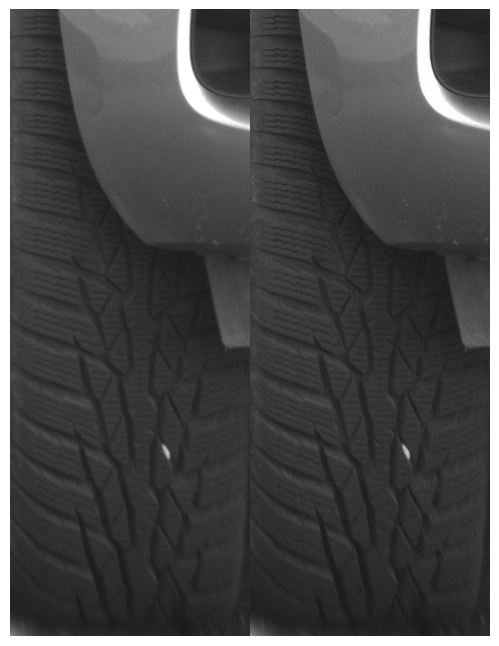

In [112]:
display_image(stack_images(original_image, scale_image(upscaled_image, 1/factor)))

We can even try upscaling the image multiple times! However, this amplifies the added noise significantly. 

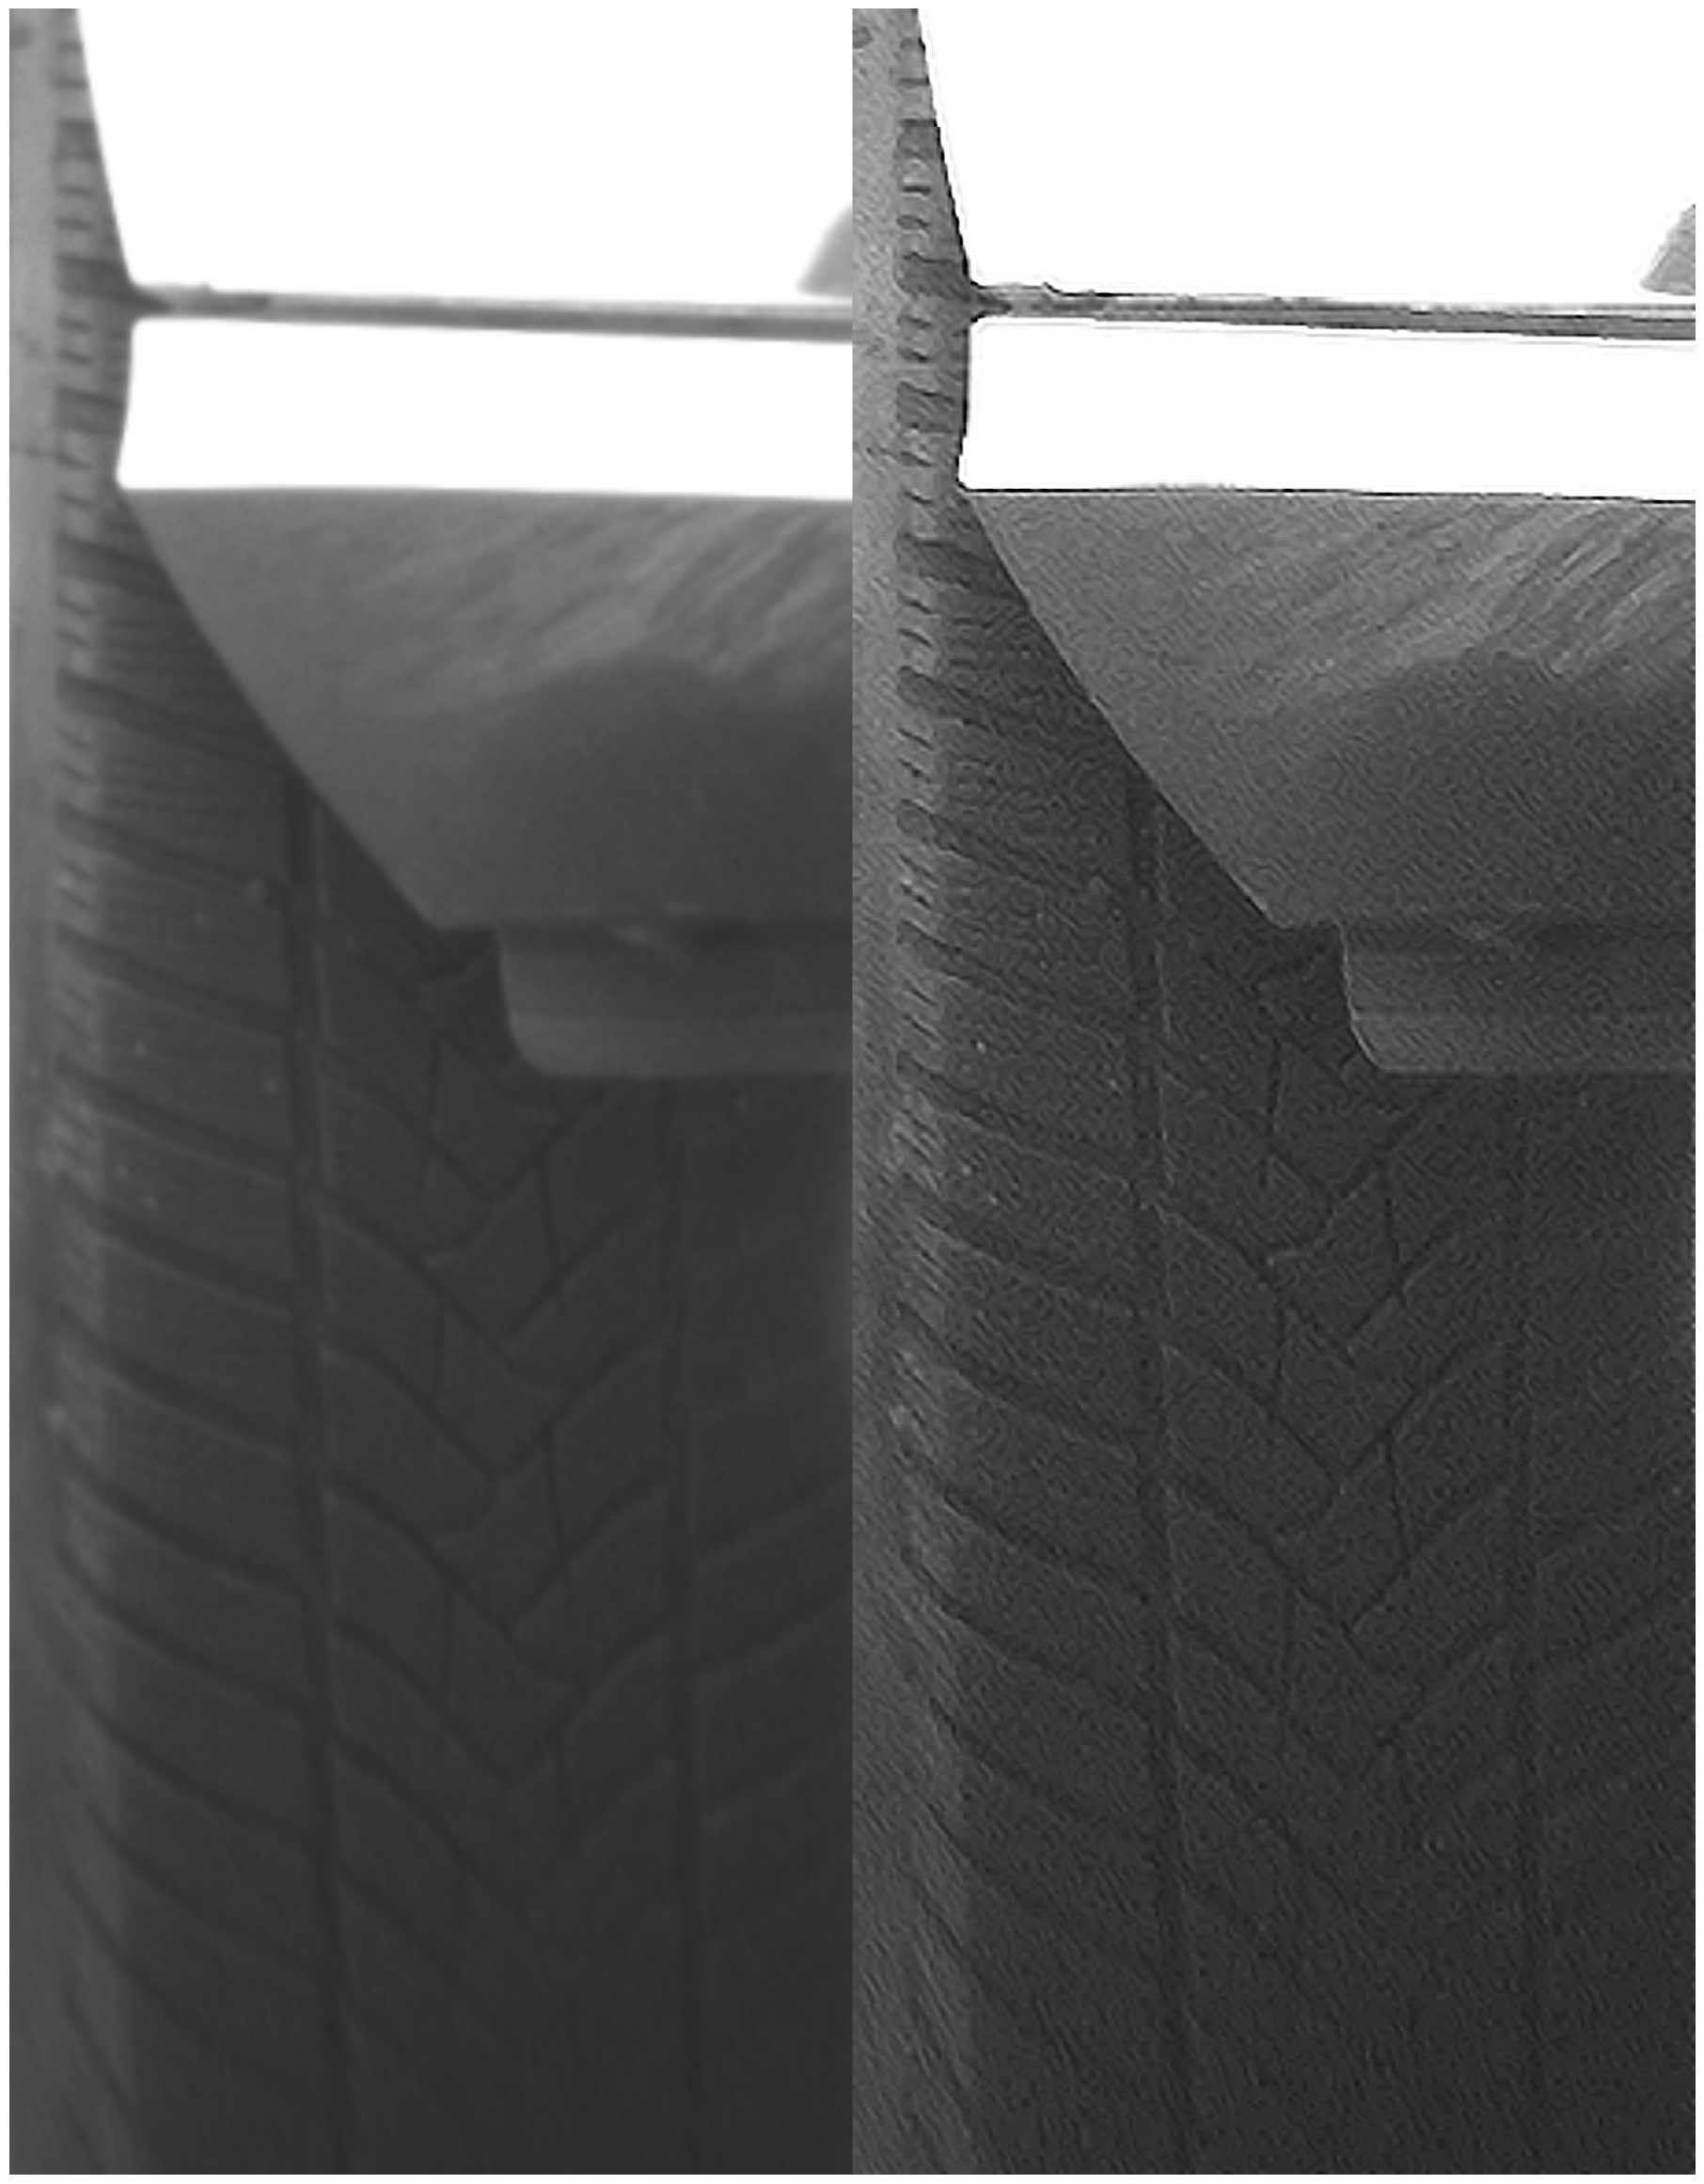

In [23]:
original_image = testing_set[0]
upscaled_image = original_image
repeats = 4

for i in range(repeats):
    upscaled_image = model.upsample(upscaled_image, factor)
    if i != repeats - 1:
        # Median blur is necessary to tone down the random noise
        upscaled_image = cv2.medianBlur(upscaled_image, 7)
        upscaled_image = scale_image(upscaled_image, 1/factor)
        
display_image(stack_images(scale_image(original_image, factor), upscaled_image))

Finally, let's pray for miracles on a low resolution image (spoiler alert: there's no CSI level enhancement https://www.youtube.com/watch?v=I_8ZH1Ggjk0 achieved, sadly).

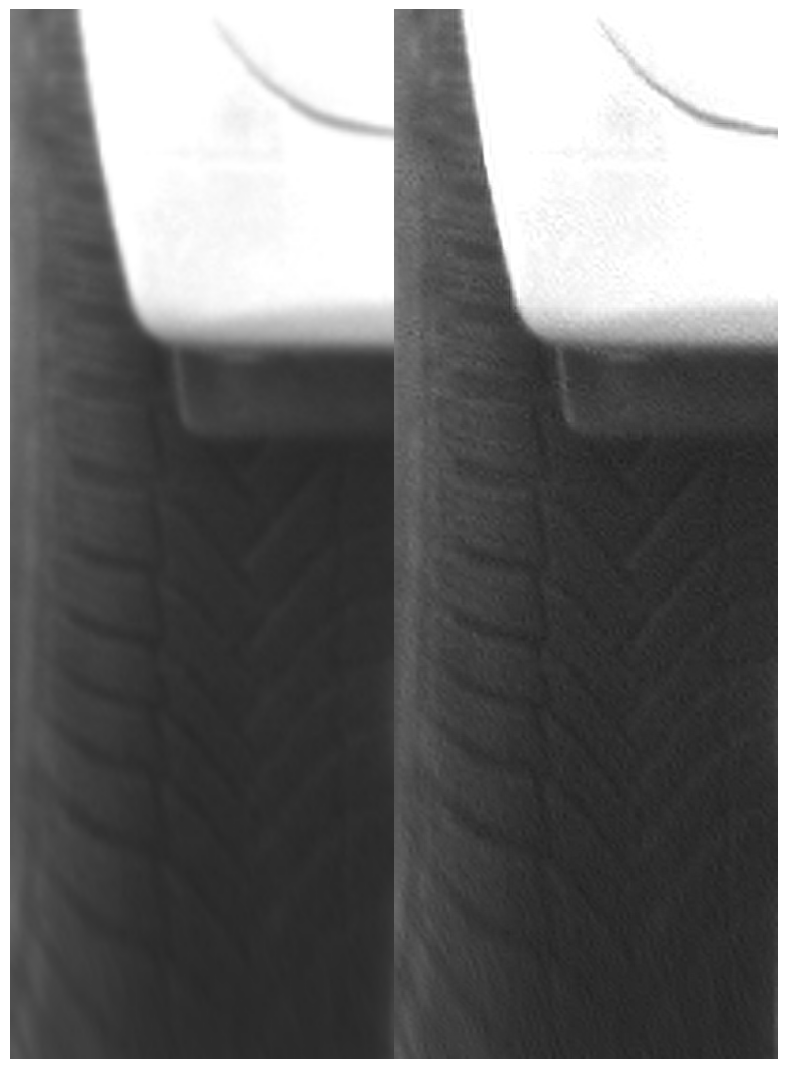

In [24]:
original_image = random.choice(low_res)
upscaled_image = model.upsample(original_image, factor)

display_image(stack_images(scale_image(original_image, factor), upscaled_image))

# Testing DeepAI's SRGAN

I'll be using their API (https://deepai.org/machine-learning-model/torch-srgan) which is limited to 5 API calls. But this can be circumvented by using a proxy or a VPN or just a dynamic IP address.

In [37]:
for i, img in enumerate(testing_set):
    cv2.imwrite(f'downsampled/{i}.png', downsample_image(img, 4))

In [51]:
import requests

for i in range(9, len(testing_set)):
    r = requests.post(
        "https://api.deepai.org/api/torch-srgan",
        files={
            'image': open(f'downsampled/{i}.png', 'rb'),
        },
        headers={'api-key': 'quickstart-QUdJIGlzIGNvbWluZy4uLi4K'}
    )
    if r.status_code == 200:
        response = requests.get(r.json()['output_url'])
        with open(f'srgan_upsampled/{i}_up.jpg', 'wb') as f:
            f.write(response.content)
    else:
        print('5 API calls consumed, change IP and resume...')
        break